Main pollutants PM10 & PM2.5, NO2, CO2, O3


CAMS global reanalysis EAC4 - Data Preparation (according to what Virgilio gave in matlab scripts)

Single level

In [ ]:
# To separate monthly files when downloading the full year - DONE for 2023-2024 nov

import xarray as xr
import pandas as pd

# Load the dataset
file_path = r"E:\IPMA\CAMS\chem_singlvl\0raw_2023_2024\CAMS_global_reanalysis_EAC4_chem_singlvl_2024.nc"
ds = xr.open_dataset(file_path)

# Ensure valid_time is a datetime object
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)

# Get unique years in the dataset
years = pd.Series(ds['valid_time'].dt.year.values).unique()

# Iterate through years and months
dest_folder = r"E:\IPMA\CAMS\chem_singlvl\0raw_2023_2024"
for year in years:
    for month in range(1, 13):
        # Filter dataset for the given year and month
        monthly_ds = ds.sel(valid_time=(ds.valid_time.dt.year == year) & (ds.valid_time.dt.month == month))

        if monthly_ds.valid_time.size > 0:  # Only save if data exists for the month
            output_filename = rf"{dest_folder}\CAMS_global_reanalysis_EAC4_chem_singlvl_{year}{month:02d}.nc"
            monthly_ds.to_netcdf(output_filename)
            print(f"Saved {output_filename}")

# Close the dataset
ds.close()

In [ ]:
# To change valid_time to time (so it matches) - DONE for 2023-2024 nov

import xarray as xr
import os
import glob

# Path to your directory containing the NetCDF files
input_dir = r"E:\IPMA\CAMS\chem_singlvl\0raw_2023_2024"
output_dir = r"E:\IPMA\CAMS\chem_singlvl\1raw_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

# Loop through each file
for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Check if 'valid_time' exists and rename it to 'time'
    if 'valid_time' in ds:
        ds = ds.rename({"valid_time": "time"})

    # Get the filename and create the output path in the new directory
    output_file = os.path.join(output_dir, os.path.basename(file_path))

    # Save the updated dataset to the output directory (overwrite original file in the new folder)
    ds.to_netcdf(output_file)

    print(f"Renamed 'valid_time' to 'time' and saved to {output_file}")

print("Renaming and saving to new folder complete!")


In [ ]:
# To convert coords from 0 to 360 to -180 to 180 - DONE for 2003-2024

import os
import xarray as xr
import numpy as np

# Define input and output folders
input_folder = r"E:\IPMA\CAMS\chem_singlvl\1raw_2003_2024"
output_folder = r"E:\IPMA\CAMS\chem_singlvl\2transformation_2003_2024"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get list of NetCDF files in the input folder
nc_files = [f for f in os.listdir(input_folder) if f.endswith(".nc")]

# Process each file
for nc_file in nc_files:
    input_path = os.path.join(input_folder, nc_file)
    output_path = os.path.join(output_folder, nc_file)

    print(f"Processing: {nc_file}")

    # Open the dataset
    ds = xr.open_dataset(input_path)

    # Extract longitude and latitude
    lon = ds['longitude'].values  # (480,)
    lat = ds['latitude'].values   # (241,)

    # Convert longitude from 0-360 to -180 to 180
    lon2 = (lon + 180) % 360 - 180

    # Swap the first and second halves
    lon3 = np.copy(lon2)
    lon3[:240] = lon2[240:480]
    lon3[240:480] = lon2[:240]

    # Create a meshgrid (not strictly needed for saving, but useful)
    LON, LAT = np.meshgrid(lon3, lat)

    # Apply the same transformation to pm10, pm1, and pm2p5
    for var in ["pm10", "pm1", "pm2p5"]:
        if var in ds:
            data = ds[var].values  # Shape: (time, lat, lon)
            transformed_data = np.copy(data)

            # Swap the longitude axis (last axis)
            transformed_data[:, :, :240] = data[:, :, 240:480]
            transformed_data[:, :, 240:480] = data[:, :, :240]

            # Replace the dataset variable with the corrected data
            ds[var].values = transformed_data

    # Update longitude in the dataset
    ds = ds.assign_coords(longitude=lon3)

    # Save the modified dataset
    ds.to_netcdf(output_path)

    print(f"Saved transformed file: {output_path}")



In [ ]:
# To crop to study area - DONE for 2003-2024

import xarray as xr
import os
import glob

# Define your study area (lat_max, lon_min, lat_min, lon_max)
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36

# Input and output directories
input_dir = r"E:\IPMA\CAMS\chem_singlvl\2transformation_2003_2024"
output_dir = r"E:\IPMA\CAMS\chem_singlvl\3cropped_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Ensure latitude slicing is correct (since it decreases from 90 to -90)
    ds_cropped = ds.sel(
        latitude=slice(lat_max, lat_min),  # lat_max is greater than lat_min
        longitude=slice(lon_min, lon_max)  # lon_min is less than lon_max
    )

    # Define output file path
    output_file = os.path.join(output_dir, os.path.basename(file_path))

    # Save the cropped dataset
    ds_cropped.to_netcdf(output_file)
    print(f"Saved cropped file to {output_file}")

print("Processing complete!")

In [ ]:
# To convert PM from kg/m3 to ug/m3 - DONE

import xarray as xr
import glob
import os

# Define input and output directories
input_folder = r"E:\IPMA\CAMS\chem_singlvl\3cropped_2003_2024"
output_folder = r"E:\IPMA\CAMS\chem_singlvl\4conversion_2003_2024"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# List of NetCDF files
nc_files = glob.glob(os.path.join(input_folder, "*.nc"))

for nc_file in nc_files:
    try:
        # Open the NetCDF file
        ds = xr.open_dataset(nc_file)

        # Convert PM values to µg/m³
        ds["pm1"] = ds["pm1"] * 1e9
        ds["pm2p5"] = ds["pm2p5"] * 1e9
        ds["pm10"] = ds["pm10"] * 1e9

        # Get the filename and construct output path
        filename = os.path.basename(nc_file)  # Extracts filename only
        output_file = os.path.join(output_folder, filename)  # Keeps same filename in new folder

        # Save the modified NetCDF file in the new folder
        ds.to_netcdf(output_file)
        ds.close()  # Close the dataset

    except Exception as e:
        print(f"Error processing {nc_file}: {e}")


In [ ]:
# To put together files for each year - DONE for 2003-2024 (final step)

import xarray as xr
import glob
import os

# Define the original path where the files are located
input_path = r"E:\IPMA\CAMS\chem_singlvl\4conversion_2003_2024"

# Define the new path where you want to save the compiled files
output_path_base = r"E:\IPMA\CAMS\chem_singlvl\5compile_2003_2024"

# Make sure the output directory exists
os.makedirs(output_path_base, exist_ok=True)

# Loop over each year from 2003 to 2024
for year in range(2003, 2025):
    # Create the file pattern for the specific year (e.g., 2003*)
    file_pattern = os.path.join(input_path, f"CAMS_global_reanalysis_EAC4_chem_singlvl_{year}*.nc")
    
    # Use glob to find all .nc files for the specified year
    files = glob.glob(file_pattern)
    
    if files:  # Only proceed if there are files for that year
        # Open all files for the year and concatenate along the 'time' dimension
        ds = xr.open_mfdataset(files, combine='by_coords')

        # Save the compiled dataset to the new path
        output_path = os.path.join(output_path_base, f"CAMS_global_reanalysis_EAC4_chem_singlvl_{year}.nc")
        ds.to_netcdf(output_path)

        print(f"Files for {year} have been compiled into: {output_path}")
    else:
        print(f"No files found for {year}.")



Multi level

In [ ]:
# To separate monthly files when downloading the full year - DONE for 2023-2024 nov

import xarray as xr
import pandas as pd

# Load the dataset
file_path = r"E:\IPMA\CAMS\chem_multlvl\0raw_2023_2024\CAMS_global_reanalysis_EAC4_chem_multlvl_2024.nc"
ds = xr.open_dataset(file_path)

# Ensure valid_time is a datetime object
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)

# Get unique years in the dataset
years = pd.Series(ds['valid_time'].dt.year.values).unique()

# Iterate through years and months
dest_folder = r"E:\IPMA\CAMS\chem_multlvl\0raw_2023_2024"
for year in years:
    for month in range(1, 13):
        # Filter dataset for the given year and month
        monthly_ds = ds.sel(valid_time=(ds.valid_time.dt.year == year) & (ds.valid_time.dt.month == month))

        if monthly_ds.valid_time.size > 0:  # Only save if data exists for the month
            output_filename = rf"{dest_folder}\CAMS_global_reanalysis_EAC4_chem_multlvl_{year}{month:02d}.nc"
            monthly_ds.to_netcdf(output_filename)
            print(f"Saved {output_filename}")

# Close the dataset
ds.close()

In [ ]:
# To change valid_time to time + remove pressure_level if present - DONE for 2023–2024 files

import xarray as xr
import os
import glob

# Paths
input_dir = r"E:\IPMA\CAMS\chem_multlvl\0raw_2023_2024"
output_dir = r"E:\IPMA\CAMS\chem_multlvl\1raw_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

# Process each file
for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open dataset
    ds = xr.open_dataset(file_path)

    # Rename 'valid_time' to 'time' if needed
    if 'valid_time' in ds:
        ds = ds.rename({"valid_time": "time"})

    # Handle pressure_level if it's a dimension of size 1
    if "pressure_level" in ds.dims and ds.dims["pressure_level"] == 1:
        ds = ds.isel(pressure_level=0).squeeze(drop=True)

    # Drop pressure_level variable if it's still around (not a dimension)
    if "pressure_level" in ds.variables and "pressure_level" not in ds.dims:
        ds = ds.drop_vars("pressure_level")

    # Save cleaned dataset
    output_file = os.path.join(output_dir, os.path.basename(file_path))
    ds.to_netcdf(output_file)

    print(f"Saved cleaned file to: {output_file}")

print("✅ All files processed!")


In [ ]:
# To convert coords from 0 to 360 to -180 to 180 - DONE for 2003-2024

import os
import xarray as xr
import numpy as np

# Define input and output folders
input_folder = r"E:\IPMA\CAMS\chem_multlvl\1raw_2003_2024"
output_folder = r"E:\IPMA\CAMS\chem_multlvl\2transformation_2003_2024"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get list of NetCDF files in the input folder
nc_files = [f for f in os.listdir(input_folder) if f.endswith(".nc")]

# Process each file
for nc_file in nc_files:
    input_path = os.path.join(input_folder, nc_file)
    output_path = os.path.join(output_folder, nc_file)

    print(f"Processing: {nc_file}")

    # Open the dataset
    ds = xr.open_dataset(input_path)

    # Extract longitude and latitude
    lon = ds['longitude'].values  # (480,)
    lat = ds['latitude'].values   # (241,)

    # Convert longitude from 0-360 to -180 to 180
    lon2 = (lon + 180) % 360 - 180

    # Swap the first and second halves
    lon3 = np.copy(lon2)
    lon3[:240] = lon2[240:480]
    lon3[240:480] = lon2[:240]

    # Create a meshgrid (not strictly needed for saving, but useful)
    LON, LAT = np.meshgrid(lon3, lat)

    # Apply the same transformation to co, no2, and go3
    for var in ["co", "no2", "no", "go3"]:
        if var in ds:
            data = ds[var].values  # Shape: (time, lat, lon)
            transformed_data = np.copy(data)

            # Swap the longitude axis (last axis)
            transformed_data[:, :, :240] = data[:, :, 240:480]
            transformed_data[:, :, 240:480] = data[:, :, :240]

            # Replace the dataset variable with the corrected data
            ds[var].values = transformed_data

    # Update longitude in the dataset
    ds = ds.assign_coords(longitude=lon3)

    # Save the modified dataset
    ds.to_netcdf(output_path)

    print(f"Saved transformed file: {output_path}")



In [ ]:
# To crop to study area - DONE for 2003-2024

import xarray as xr
import os
import glob

# Define your study area (lat_max, lon_min, lat_min, lon_max)
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36

# Input and output directories
input_dir = r"E:\IPMA\CAMS\chem_multlvl\2transformation_2003_2024"
output_dir = r"E:\IPMA\CAMS\chem_multlvl\3cropped_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Ensure latitude slicing is correct (since it decreases from 90 to -90)
    ds_cropped = ds.sel(
        latitude=slice(lat_max, lat_min),  # lat_max is greater than lat_min
        longitude=slice(lon_min, lon_max)  # lon_min is less than lon_max
    )

    # Define output file path
    output_file = os.path.join(output_dir, os.path.basename(file_path))

    # Save the cropped dataset
    ds_cropped.to_netcdf(output_file)
    print(f"Saved cropped file to {output_file}")

print("Processing complete!")

In [ ]:
# To convert from kg/kg to kg/m3 to ug/m3 (co in mg/m3)

import os
import xarray as xr
import numpy as np

# Paths
chem_folder = r"E:\IPMA\CAMS\chem_multlvl\3cropped_2003_2024"
temp_folder = r"E:\IPMA\CAMS\meteo_multlvl\3cropped_2003_2024"
output_folder = r"E:\IPMA\CAMS\chem_multlvl\4conversion_2003_2024"
os.makedirs(output_folder, exist_ok=True)

# Constants
pressure = 1e5  # Pa equal to 1000 hPa
R = 287.0500676  # J/(kg·K)

# Loop through chemistry files
for file in os.listdir(chem_folder):
    if file.endswith('.nc'):
        chem_path = os.path.join(chem_folder, file)

        # Replace 'chem_multlvl' with 'meteo_multlvl' to find the corresponding temp file
        temp_filename = file.replace('chem_multlvl', 'meteo_multlvl')
        temp_path = os.path.join(temp_folder, temp_filename)

        if not os.path.exists(temp_path):
            print(f"⚠ Temperature file not found for {file}")
            continue

        # Open datasets
        ds_chem = xr.open_dataset(chem_path)
        ds_temp = xr.open_dataset(temp_path)

        # Ensure 't' exists in temperature file
        if 't' not in ds_temp.variables:
            print(f"⚠ No temperature variable 't' in {temp_filename}")
            continue

        # Align time and space
        ds_chem, ds_temp = xr.align(ds_chem, ds_temp, join='inner')
        t = ds_temp['t']

        # STEP 1: kg/kg → kg/m³
        co_kgm3 = ds_chem['co'] * pressure / (R * t)
        no2_kgm3 = ds_chem['no2'] * pressure / (R * t)
        no_kgm3 = ds_chem['no'] * pressure / (R * t)
        go3_kgm3 = ds_chem['go3'] * pressure / (R * t)

        # STEP 2: kg/m³ → final units
        co_final = co_kgm3 * 1e6    # mg/m³
        no2_final = no2_kgm3 * 1e9  # µg/m³
        no_final = no_kgm3 * 1e9    # µg/m³
        go3_final = go3_kgm3 * 1e9  # µg/m³

        # Create new dataset
        new_ds = xr.Dataset({
            'co': co_final,
            'no2': no2_final,
            'no': no_final,
            'go3': go3_final
        })

        # Assign coordinates and attributes
        for coord in ds_chem.coords:
            new_ds = new_ds.assign_coords({coord: ds_chem[coord]})
        new_ds.attrs = ds_chem.attrs

        # Optional: add units metadata
        new_ds['co'].attrs['units'] = 'mg m-3'
        new_ds['no2'].attrs['units'] = 'µg m-3'
        new_ds['no'].attrs['units'] = 'µg m-3'
        new_ds['go3'].attrs['units'] = 'µg m-3'

        # Save output
        output_path = os.path.join(output_folder, f"{file}")
        new_ds.to_netcdf(output_path)

        print(f"✔ Converted and saved: {output_path}")

In [ ]:
# To put together files for each year - DONE for 2003-2024 (final step)

import xarray as xr
import glob
import os

# Define the original path where the files are located
input_path = r"E:\IPMA\CAMS\chem_multlvl\4conversion_2003_2024"

# Define the new path where you want to save the compiled files
output_path_base = r"E:\IPMA\CAMS\chem_multlvl\5compile_2003_2024"

# Make sure the output directory exists
os.makedirs(output_path_base, exist_ok=True)

# Loop over each year from 2003 to 2024
for year in range(2003, 2025):
    # Create the file pattern for the specific year (e.g., 2003*)
    file_pattern = os.path.join(input_path, f"CAMS_global_reanalysis_EAC4_chem_multlvl_{year}*.nc")
    
    # Use glob to find all .nc files for the specified year
    files = glob.glob(file_pattern)
    
    if files:  # Only proceed if there are files for that year
        # Open all files for the year and concatenate along the 'time' dimension
        ds = xr.open_mfdataset(files, combine='by_coords')

        # Save the compiled dataset to the new path
        output_path = os.path.join(output_path_base, f"CAMS_global_reanalysis_EAC4_chem_multlvl_{year}.nc")
        ds.to_netcdf(output_path)

        print(f"Files for {year} have been compiled into: {output_path}")
    else:
        print(f"No files found for {year}.")



Meteo multlvl

In [ ]:
# To separate monthly files when downloading the full year - DONE for 2023-2024 nov

import xarray as xr
import pandas as pd

# Load the dataset
file_path = r"E:\IPMA\CAMS\meteo_multlvl\0raw_2023_2024\CAMS_global_reanalysis_EAC4_meteo_multlvl_2024.nc"
ds = xr.open_dataset(file_path)

# Ensure valid_time is a datetime object
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)

# Get unique years in the dataset
years = pd.Series(ds['valid_time'].dt.year.values).unique()

# Iterate through years and months
dest_folder = r"E:\IPMA\CAMS\meteo_multlvl\0raw_2023_2024"
for year in years:
    for month in range(1, 13):
        # Filter dataset for the given year and month
        monthly_ds = ds.sel(valid_time=(ds.valid_time.dt.year == year) & (ds.valid_time.dt.month == month))

        if monthly_ds.valid_time.size > 0:  # Only save if data exists for the month
            output_filename = rf"{dest_folder}\CAMS_global_reanalysis_EAC4_meteo_multlvl_{year}{month:02d}.nc"
            monthly_ds.to_netcdf(output_filename)
            print(f"Saved {output_filename}")

# Close the dataset
ds.close()

In [ ]:
# To change valid_time to time + remove pressure_level if present - DONE for 2023–2024 files

import xarray as xr
import os
import glob

# Paths
input_dir = r"E:\IPMA\CAMS\meteo_multlvl\0raw_2023_2024"
output_dir = r"E:\IPMA\CAMS\meteo_multlvl\1raw_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

# Process each file
for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open dataset
    ds = xr.open_dataset(file_path)

    # Rename 'valid_time' to 'time' if needed
    if 'valid_time' in ds:
        ds = ds.rename({"valid_time": "time"})

    # Handle pressure_level if it's a dimension of size 1
    if "pressure_level" in ds.dims and ds.dims["pressure_level"] == 1:
        ds = ds.isel(pressure_level=0).squeeze(drop=True)

    # Drop pressure_level variable if it's still around (not a dimension)
    if "pressure_level" in ds.variables and "pressure_level" not in ds.dims:
        ds = ds.drop_vars("pressure_level")

    # Save cleaned dataset
    output_file = os.path.join(output_dir, os.path.basename(file_path))
    ds.to_netcdf(output_file)

    print(f"Saved cleaned file to: {output_file}")

print("✅ All files processed!")


In [ ]:
# To convert coords from 0 to 360 to -180 to 180 - DONE for 2003-2024

import os
import xarray as xr
import numpy as np

# Define input and output folders
input_folder = r"E:\IPMA\CAMS\meteo_multlvl\1raw_2003_2024"
output_folder = r"E:\IPMA\CAMS\meteo_multlvl\2transformation_2003_2024"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Get list of NetCDF files in the input folder
nc_files = [f for f in os.listdir(input_folder) if f.endswith(".nc")]

# Process each file
for nc_file in nc_files:
    input_path = os.path.join(input_folder, nc_file)
    output_path = os.path.join(output_folder, nc_file)

    print(f"Processing: {nc_file}")

    # Open the dataset
    ds = xr.open_dataset(input_path)

    # Extract longitude and latitude
    lon = ds['longitude'].values  # (480,)
    lat = ds['latitude'].values   # (241,)

    # Convert longitude from 0-360 to -180 to 180
    lon2 = (lon + 180) % 360 - 180

    # Swap the first and second halves
    lon3 = np.copy(lon2)
    lon3[:240] = lon2[240:480]
    lon3[240:480] = lon2[:240]

    # Create a meshgrid (not strictly needed for saving, but useful)
    LON, LAT = np.meshgrid(lon3, lat)

    # Apply the same transformation to co, no2, and go3
    for var in ["t", "q"]:
        if var in ds:
            data = ds[var].values  # Shape: (time, lat, lon)
            transformed_data = np.copy(data)

            # Swap the longitude axis (last axis)
            transformed_data[:, :, :240] = data[:, :, 240:480]
            transformed_data[:, :, 240:480] = data[:, :, :240]

            # Replace the dataset variable with the corrected data
            ds[var].values = transformed_data

    # Update longitude in the dataset
    ds = ds.assign_coords(longitude=lon3)

    # Save the modified dataset
    ds.to_netcdf(output_path)

    print(f"Saved transformed file: {output_path}")



In [ ]:
# To crop to study area - DONE for 2003-2024

import xarray as xr
import os
import glob

# Define your study area (lat_max, lon_min, lat_min, lon_max)
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36

# Input and output directories
input_dir = r"E:\IPMA\CAMS\meteo_multlvl\2transformation_2003_2024"
output_dir = r"E:\IPMA\CAMS\meteo_multlvl\3cropped_2003_2024"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the input directory
nc_files = glob.glob(os.path.join(input_dir, "*.nc"))

for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Ensure latitude slicing is correct (since it decreases from 90 to -90)
    ds_cropped = ds.sel(
        latitude=slice(lat_max, lat_min),  # lat_max is greater than lat_min
        longitude=slice(lon_min, lon_max)  # lon_min is less than lon_max
    )

    # Define output file path
    output_file = os.path.join(output_dir, os.path.basename(file_path))

    # Save the cropped dataset
    ds_cropped.to_netcdf(output_file)
    print(f"Saved cropped file to {output_file}")

print("Processing complete!")

ERA5 - all 5 variables

In [ ]:
#To separate year by year files downloaded with more than 1 year each - DONE for 1979-2024

import xarray as xr
import pandas as pd

# Load the dataset
file_path = r"E:\IPMA\ERA5\UV_wind\ERA5_hourly_uv_2003_1999.nc"
ds = xr.open_dataset(file_path)

# Ensure valid_time is a datetime object
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)

# Get unique years in the dataset
years = pd.Series(ds['valid_time'].dt.year.values).unique()

# Destination folder to save yearly files
dest_folder = r"E:\IPMA\ERA5\UV_wind"

# Iterate through years
for year in years:
    # Filter dataset for the given year
    yearly_ds = ds.sel(valid_time=ds.valid_time.dt.year == year)

    if yearly_ds.valid_time.size > 0:  # Only save if data exists for the year
        output_filename = rf"{dest_folder}\ERA5_hourly_uv_{year}.nc" #change accordingly to what file is being used
        yearly_ds.to_netcdf(output_filename)
        print(f"Saved {output_filename}")

# Close the dataset
ds.close()


In [ ]:
# To separate monthly files when downloading the full year - DONE for 1979-2024

import os
import xarray as xr
import pandas as pd

# Directory where all .nc files are located
file_path = r"E:\IPMA\ERA5\UV_wind\1raw_year_1979_2024"

# Destination folder for monthly files
dest_folder = r"E:\IPMA\ERA5\UV_wind\1raw_month_1979_2024"

# Iterate over each file in the directory
for filename in os.listdir(file_path):
    if filename.endswith(".nc"):
        file_full_path = os.path.join(file_path, filename)
        
        # Load the dataset
        ds = xr.open_dataset(file_full_path)

        # Ensure valid_time is a datetime object
        ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)

        # Get unique years in the dataset
        years = pd.Series(ds['valid_time'].dt.year.values).unique()

        # Iterate through years and months
        for year in years:
            for month in range(1, 13):
                # Filter dataset for the given year and month
                monthly_ds = ds.sel(valid_time=(ds.valid_time.dt.year == year) & (ds.valid_time.dt.month == month))

                if monthly_ds.valid_time.size > 0:  # Only save if data exists for the month
                    output_filename = rf"{dest_folder}\ERA5_hourly_uv_{year}{month:02d}.nc" #change accordingly to what file is being used
                    monthly_ds.to_netcdf(output_filename)
                    print(f"Saved {output_filename}")

        # Close the dataset
        ds.close()


In [ ]:
# To change Kelvin to Celsius - DONE for temperature

import xarray as xr
import os
import glob

# Define the folder containing the NetCDF files
data_dir = r"E:\IPMA\ERA5\Temperature\1raw_year_1979_2024"
# Define the folder to save the converted files
output_dir = r"E:\IPMA\ERA5\Temperature\2conversion_year_1979_2024"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all NetCDF files in the directory
nc_files = glob.glob(os.path.join(data_dir, "*.nc"))

# Loop through each file
for file_path in nc_files:
    print(f"Processing {file_path}...")

    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Check if 't2m' exists and convert it from Kelvin to Celsius
    if "t2m" in ds:
        ds["t2m"] = ds["t2m"] - 273.15  # Convert to Celsius
        ds["t2m"].attrs["units"] = "Celsius"  # Update metadata

        # Define output file path
        output_file_path = os.path.join(output_dir, os.path.basename(file_path))
        
        # Save the updated dataset to the new folder
        ds.to_netcdf(output_file_path, mode="w")

        print(f"Converted 't2m' to Celsius and saved to {output_file_path}")
    else:
        print(f"Skipping {file_path}, 't2m' variable not found.")


FRP

In [ ]:
# To put together all the csv files into one - DONE

import pandas as pd
import os

# Folder containing the CSV files
folder_path = r"E:\IPMA\FRP"

# Get all CSV file paths from the folder
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Read and concatenate the files
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Save the merged dataset
df.to_csv(os.path.join(folder_path, "FRP_2001_2023.csv"), index=False)

print("All CSV files in the folder merged successfully!")


SPEI

In [ ]:
# To convert .npy to .nc files - RAQUEL SOURCE - DONE

import numpy as np
import xarray as xr
import os

# Folder containing .npy files
input_folder = r"E:\IPMA\SPI\SPI3"
output_folder = r"E:\IPMA\SPI\SPI3\nc"

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all .npy files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".npy"):  # Process only .npy files
        file_path = os.path.join(input_folder, filename)
        data = np.load(file_path)  # Load the 3D array

        # Define dimensions (adjust accordingly)
        dims = ("time", "lat", "lon")  # Change based on data structure
        coords = {
            "time": np.arange(data.shape[0]),  # Modify based on actual data
            "lat": np.linspace(34, 66, data.shape[1]),  # Modify latitudes
            "lon": np.linspace(-12, 36, data.shape[2])  # Modify longitudes
        }

        # Convert to xarray DataArray
        da = xr.DataArray(data, dims=dims, coords=coords, name="spi03")

        # Convert to Dataset
        ds = da.to_dataset(name="spi03")

        # Save as NetCDF file
        output_filename = filename.replace(".npy", ".nc")
        output_path = os.path.join(output_folder, output_filename)
        ds.to_netcdf(output_path)

        print(f"Converted {filename} -> {output_filename}")

print("Batch conversion complete!")


In [ ]:
# To separate spei for 1979-2024 - WEB SOURCE - DONE

import pandas as pd
import xarray as xr

def extract_spei_data(input_file, start_year=1979, end_year=2024):
    """
    Extracts data from a NetCDF file for the years between start_year and end_year and saves it to a new NetCDF file.
    
    Args:
        input_file (str): Path to the input NetCDF file.
        start_year (int): Start year for extraction (default 1979).
        end_year (int): End year for extraction (default 2024).
    """
    # Open the NetCDF file using xarray
    ds = xr.open_dataset(input_file)

    # Ensure time is in datetime format (if it's not already in datetime format)
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Filter the data based on the time dimension (between the start and end year)
    filtered_ds = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    
    # Create output filename dynamically based on the input file name and year range
    base_filename = input_file.split('/')[-1].split('.')[0]  # Extract file name (e.g., spei_01)
    output_file = f"{base_filename}_{start_year}-{end_year}.nc"
    
    # Save the filtered dataset to a new NetCDF file
    filtered_ds.to_netcdf(output_file)
    print(f"Saved filtered data to: {output_file}")

# Example usage:
input_file = r"E:\IPMA\SPEIbase_v2-10\SPEI12\spei12.nc"
extract_spei_data(input_file)


In [ ]:
# To separate spei for each year between 1979-2024 - WEB SOURCE - DONE

import xarray as xr
import pandas as pd

def extract_spei_data_by_year(input_file, start_year=1979, end_year=2024):
    """
    Extracts data from a NetCDF file for each year between start_year and end_year
    and saves each year as a separate NetCDF file.
    
    Args:
        input_file (str): Path to the input NetCDF file.
        start_year (int): Start year for extraction (default 1979).
        end_year (int): End year for extraction (default 2024).
    """
    # Open the NetCDF file using xarray
    ds = xr.open_dataset(input_file)

    # Ensure time is in datetime format (if it's not already in datetime format)
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Loop through each year and extract the data for that year
    for year in range(start_year, end_year + 1):
        # Filter the dataset for the current year
        filtered_ds = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
        
        # Create output filename for each year
        base_filename = input_file.split('/')[-1].split('.')[0]  # Extract file name (e.g., spei_01)
        output_file = f"{base_filename}_{year}.nc"
        
        # Save the filtered data for this year to a new NetCDF file
        filtered_ds.to_netcdf(output_file)
        print(f"Saved filtered data for {year} to: {output_file}")

# Example usage:
input_file = r"E:\IPMA\SPEIbase_v2-10\SPEI12\spei12.nc"
extract_spei_data_by_year(input_file)


In [ ]:
# To crop to study area - WEB SOURCE - DONE for 1979-2023

import os
import xarray as xr

# Define your input and output directories
input_dir = r"E:\IPMA\SPEIbase_v2-10\SPEI12\1raw_1979_2023"
output_dir = r"E:\IPMA\SPEIbase_v2-10\SPEI12\2cropped_1979_2023"

# Define the latitude and longitude boundaries for your study area
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36  # Study area for Europe

# Make sure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all NC files in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".nc"):  # Check if it's a NetCDF file
        input_file_path = os.path.join(input_dir, file_name)

        # Open the NetCDF file using xarray
        with xr.open_dataset(input_file_path) as ds:
            # Crop the dataset to include only the specified region
            ds_europe = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

            # Create the output file path
            output_file_path = os.path.join(output_dir, file_name)

            # Save the cropped data to a new NetCDF file
            ds_europe.to_netcdf(output_file_path)
            print(f"Saved cropped file: {output_file_path}")


Study Areas

In [ ]:
# To obtain every study area needed and its respective coordinates
# North, West, South, East

#general_study_area
lat_max, lon_min, lat_min, lon_max = 66, -12, 34, 36

#portugal_area
lat_max, lon_min, lat_min, lon_max = 43, -10, 36, -6

#iberia_area
lat_max, lon_min, lat_min, lon_max = 45, -10, 35, 5

#south_europe
lat_max, lon_min, lat_min, lon_max = 45, -10, 34, 29

#greece
lat_max, lon_min, lat_min, lon_max = 42, 19, 34, 29

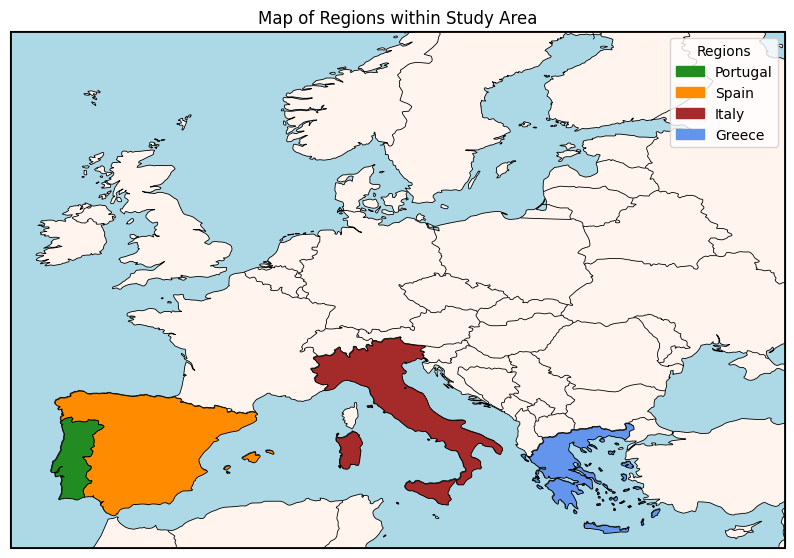

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

# Define countries and their colors
country_colors = {
    "Portugal": "forestgreen",
    "Spain": "darkorange",
    "Italy": "brown",
    "Greece": "cornflowerblue",
}

# Study Area bounds (lat_min, lat_max, lon_min, lon_max)
study_area_bounds = (34, 66, -12, 36)

# Setup plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34, 66], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Draw Study Area boundary (no fill, just edge)
lat_min, lat_max, lon_min, lon_max = study_area_bounds
ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, label='Study Area')

# Load countries shapefile
shpfilename = shapereader.natural_earth(resolution='50m',
                                       category='cultural',
                                       name='admin_0_countries')
reader = shapereader.Reader(shpfilename)

# Plot each country with assigned color
handles = []
for record in reader.records():
    country_name = record.attributes['NAME_LONG']
    geom = record.geometry

    if country_name in country_colors:
        patch = ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                                 facecolor=country_colors[country_name],
                                 edgecolor='black', linewidth=0.6)
        handles.append(patch)

# Create custom legend handles for the countries
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=color, label=country) for country, color in country_colors.items()]

# Add legend with title 'Regions'
plt.legend(handles=legend_handles, loc='upper right', title='Regions')

plt.title('Map of Regions within Study Area')
plt.show()
